## Installation


In [193]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from functools import partial
import circuitsvis as cv

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from numpy.linalg import norm
import einops

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy
torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [194]:
import plotly.express as px

## Data


In [195]:
examples_selection = [{'base_string': 'The guard appreciated getting treatment from the nurse because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'nurse', 'male_occupation': 'guard', 'female_occupation_continuation': ' did a good job.', 'male_occupation_continuation': ' felt very sick.'},
{'base_string': "The manager agreed to raise the assistant 's salary because {}", 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'assistant', 'male_occupation': 'manager', 'female_occupation_continuation': ' worked very hard.', 'male_occupation_continuation': ' is a generous man.'},
{'base_string': "The carpenter tried to prepare for the auditor 's visit but {}", 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'auditor', 'male_occupation': 'carpenter', 'female_occupation_continuation': ' demanded too much.', 'male_occupation_continuation': ' did not have the correct paperwork.'},
{'base_string': 'The driver transported the housekeeper to the job because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'housekeeper', 'male_occupation': 'driver', 'female_occupation_continuation': ' was beautiful.', 'male_occupation_continuation': ' had a car.'},
{'base_string': 'The manager promised to give a raise to the teacher because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'teacher', 'male_occupation': 'manager', 'female_occupation_continuation': ' performed well.', 'male_occupation_continuation': ' was generous.'},
{'base_string': 'The driver never drove the librarian anywhere because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'librarian', 'male_occupation': 'driver', 'female_occupation_continuation': ' wore silly hats.', 'male_occupation_continuation': ' was embarrassed.'},
{'base_string': 'The lawyer helped the cleaner win the case without pay because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'cleaner', 'male_occupation': 'lawyer', 'female_occupation_continuation': ' is too poor to afford that.', 'male_occupation_continuation': ' is a very generous man.'},
{'base_string': 'The sheriff asked the accountant many questions because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'accountant', 'male_occupation': 'sheriff', 'female_occupation_continuation': ' was suspected of stealing the money.', 'male_occupation_continuation': ' is a suspicious man.'},
{'base_string': 'The nurse examined the farmer for injuries because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'nurse', 'male_occupation': 'farmer', 'female_occupation_continuation': ' was caring.', 'male_occupation_continuation': ' was screaming.'},
{'base_string': 'The CEO ordered the cleaner out of the room because {}', 'female_pronoun': 'she', 'male_pronoun': 'he', 'female_occupation': 'cleaner', 'male_occupation': 'ceo', 'female_occupation_continuation': ' was nosey.', 'male_occupation_continuation': ' wanted privacy.'}]



## Import Models


In [196]:
device = "cuda" if torch.cuda.is_available() else "mps"
model_name = 'gpt2'
model = HookedTransformer.from_pretrained(model_name, device = device)

Loaded pretrained model gpt2 into HookedTransformer


## Metrics

First, we need to define our measure of grammatical gender bias in the model.

This is defined in the paper as the relative probabilities:

$$\textbf{y}_{x}(u) = \frac{p_{\theta}(\text{anti-stereotypical} | u)}{p_{\theta}(\text{stereotypical} | u)}$$

A $y$ value close to 1 indicates less bias since the probabilities are similar for predicting the stereotypical and anti-stereotypical candidates.

Using our nurse and farmer example:

$y_{\texttt{null}}(u)$ represents this ratio for our original prompt: "The nurse examined the farmer for injuries because she..."

$y_{\texttt{set-gender}}(u)$ represents this ratio after a $\texttt{set-gender}$ operation is performed on this prompt to swap out the gendered pronoun: "The nurse examined the farmer for injuries because he..."


In [197]:
def get_probability_multi_token(logits, context, candidate):
    """
    logits.size = [1, seq, vocab_size]
    context_batch.size = [1, num tokens context]
    candidate_batch.size = [1 num tokens candidate]
    """
    log_probs = torch.log_softmax(logits, dim=-1)

    context_len = context.shape[1]
    log_prob = 0  # probs for each token in the candidate

    for i, token in enumerate((candidate[0])): 
        cand_pos = context_len - 1 + i
        # P (cand_token_1 | context)
        # logits[t][k] -> P(T_{t+1} = vocab[k] | T0, T1, ..., T_{t-1}, T_t)
        token_prob = log_probs[0, cand_pos, token]
        log_prob += token_prob

    geometric_mean = torch.exp(log_prob / len(candidate[0])).item()
    return float(geometric_mean)


In [198]:
def get_logits(context, candidate):
    context_tokens = model.to_tokens(context, prepend_bos = False)
    candidate_tokens = model.to_tokens(candidate, prepend_bos = False)
    logits, _ = model.run_with_cache(torch.concat((context_tokens, candidate_tokens), dim = 1))
    return logits, context_tokens, candidate_tokens

#### Unit Tests


In [199]:
def test_probability_multi_token(example):
    logits, context_tokens, candidate_tokens = get_logits(example['base_string'].format(example['female_pronoun']), example['female_occupation_continuation'])
    ff_probability = get_probability_multi_token(logits, context_tokens, candidate_tokens)

    logits, context_tokens, candidate_tokens = get_logits(example['base_string'].format(example['female_pronoun']), example['male_occupation_continuation'])
    fm_probability = get_probability_multi_token(logits, context_tokens, candidate_tokens)

    logits, context_tokens, candidate_tokens = get_logits(example['base_string'].format(example['male_pronoun']), example['female_occupation_continuation'])
    mf_probability = get_probability_multi_token(logits, context_tokens, candidate_tokens)

    logits, context_tokens, candidate_tokens = get_logits(example['base_string'].format(example['male_pronoun']), example['male_occupation_continuation'])
    mm_probability = get_probability_multi_token(logits, context_tokens, candidate_tokens)

    print(f"ff: {ff_probability:.8f}")
    print(f"fm: {fm_probability:.8f}")
    print(f"mf: {mf_probability:.8f}")
    print(f"mm: {mm_probability:.8f}")

In [200]:
test_probability_multi_token(test_example1)
print()
test_probability_multi_token(test_example2)

ff: 0.00093320
fm: 0.00098415
mf: 0.00097974
mm: 0.00103403

ff: 0.00043592
fm: 0.00127099
mf: 0.00043886
mm: 0.00130727


## Total Effect


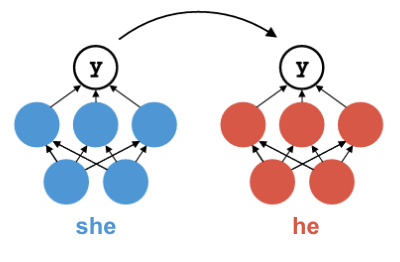


> **Total effect** measures the change in $y$ after swapping out the context associated with the gendered pronoun. The magnitude of the total effect indicates how much "bias" is associated with an example

In the above example, this would involve swapping the _she_ in the original prompt to be _he_ in the new prompt. Thus, a larger total effect would mean there is a higher chance of predicting _was screaming_ as a response to our original prompt.

$$\textbf{TE}(\texttt{set-gender}, \texttt{null}; \textbf{y}, u) = \frac{\textbf{y}_{\texttt{set-gender}}(u) - \textbf{y}_{\texttt{null}}(u)}{\textbf{y}_{\texttt{null}}(u)}$$


In [201]:
def get_y_null(example): 
    logits, context_tokens, candidate_tokens = get_logits(example['base_string'].format(example['female_pronoun']), example['female_occupation_continuation'])
    ff_probability = get_probability_multi_token(logits, context_tokens, candidate_tokens)

    logits, context_tokens, candidate_tokens = get_logits(example['base_string'].format(example['female_pronoun']), example['male_occupation_continuation'])
    fm_probability = get_probability_multi_token(logits, context_tokens, candidate_tokens)

    return fm_probability / ff_probability

In [202]:
def total_effect(model, base):
  pass

#### Unit Tests


In [203]:
np.testing.assert_approx_equal(total_effect(model, test_example1), 0.6669689416)
np.testing.assert_approx_equal(total_effect(model, test_example2), -0.089053630)

TypeError: float() argument must be a string or a real number, not 'NoneType'

## Attention Intervention


### Direct Effect


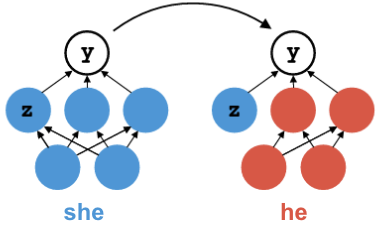


> **Direct effect** measures the change in $y$ after swapping out all attention heads associated with the gendered pronoun but one.

For the above example, you can think of the direct effect as how much more the model predicts "was screaming" for the original prompt after swapping out **all but one** attention head.

$$\textbf{NDE}(\texttt{set-gender}, \texttt{null}; \textbf{y}, u) = \mathbb{E}\left[\frac{\textbf{y}_{\texttt{set-gender}, z_{\texttt{null}(u)}}(u) }{\textbf{y}_{\texttt{null}}(u)} - 1\right]$$


### Indirect Effect


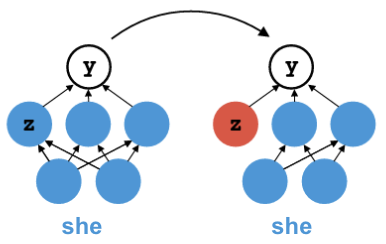


> **Indirect effect** measures the change in $y$ after swapping out a single attention head associated with the gendered pronoun.

For the above example, you can think of the indirect effect as how much more the model predicts "was screaming" for the original prompt after swapping out a **single** attention head.

$$\textbf{NIE}(\texttt{set-gender}, \texttt{null}; \textbf{y}, u) = \mathbb{E}\left[\frac{\textbf{y}_{\texttt{null}, z_{\texttt{set-gender}(u)}}(u) }{\textbf{y}_{\texttt{null}}(u)} - 1\right]$$


## Visualization


### Indirect Effect


In [ ]:
indirect = None
# indirect should be the indirect effects of shape [num_layers, num_heads]

In [ ]:
direct = None
# direct should be the indirect effects of shape [num_layers, num_heads]

Heatmap of Indirect Effects (Figure 5a)


In [ ]:
from jaxtyping import Float, Int, Bool
from typing import List, Union, Optional, Callable, Tuple, Dict

update_layout_set = {"xaxis_range", "yaxis_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor"}

def imshow(tensor, renderer=None, **kwargs):
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "facet_labels" in kwargs_pre:
        facet_labels = kwargs_pre.pop("facet_labels")
    else:
        facet_labels = None
    if "color_continuous_scale" not in kwargs_pre:
        kwargs_pre["color_continuous_scale"] = "RdBu"
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, **kwargs_pre).update_layout(**kwargs_post)
    if facet_labels:
        for i, label in enumerate(facet_labels):
            fig.layout.annotations[i]['text'] = label

    fig.show(renderer)

In [ ]:
imshow(
    indirect,
    title="Indirect Effect With Attention Intervention", labels={"x":"Head", "y":"Layer"}, zmax = 0.1, zmin = -0.1
)

In [ ]:
result_bar = None
# this should be the sum of indirect effects per layer of shape [num_layers, ]

Bar Chart of Layer Indirect Effects (Figure 5a)


In [ ]:
def bar(tensor, renderer=None, **kwargs):
    '''
    Edit to this helper function, allowing it to take args in update_layout (e.g. yaxis_range).
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    px.bar(y=utils.to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post).show(renderer)

In [ ]:
bar(result_bar, labels={"x":"Layer", "y":"Indirect Effect"})

### Direct Effect + Indirect Effect = Total Effect


In [ ]:
random_selected_heads = None
indirect_s = None
direct_s = None


Bar Chart of Decomposible Effects (Figure 11)


In [ ]:
from pandas import DataFrame as df
import plotly.graph_objects as go

def show_sum(head, indirect_s, direct_s, total):
  pd_dict = df.from_dict({"head": [str(i) for i in head], "indirect": indirect_s, "direct": direct_s, "total": [total for i in range(len(direct_s))]})
  fig = px.bar(pd_dict, x="head", y=["indirect", "direct"], color_discrete_sequence=['pink', 'skyblue'])
  line = px.line(pd_dict, x="head", y=["total"])
  line.update_traces(line=dict(dash='dash', color='orange'))
  fig.add_trace(line.data[0])
  fig.update_layout(
    title='Decompose Effect',
    xaxis_title='selected head',
    yaxis_title='effect'  # Change this label to your desired name
)
  fig.show()

In [ ]:
show_sum(random_selected_heads, indirect_s, direct_s, total_effect)

## Top K selection


In [ ]:
mean_indirect_all_heads, result = None, None
# mean_indirect_all_heads should be indirect effect for swapping all heads together averaged over examples
# result is the list of topping top-n strongest indirect heads (first entry swaps strongest, second entry swaps two strongest, ...)

Cumulative Sum of Top K Strongest Indirect Effects (Figure 5b)


In [ ]:
# Create a scatter plot
def cumulative_indirect_effect_graph(mean_indirect_all_heads, result, topk = 10):
  pd_dict = df.from_dict({"head": range(topk), "indirect_effect": result, "total_indirect": [mean_indirect_all_heads for i in range(len(result))]})
  fig = px.line(pd_dict, x="head", y = ["indirect_effect"], title="Head Selection in GPT2-small on Winobias")
  line = px.line(pd_dict, x="head", y=["total_indirect"])
  line.update_traces(line=dict(dash='dash', color='orange'))
  fig.add_trace(line.data[0])
  fig.update_layout(
    xaxis_title='number of head',
    yaxis_title='mean indirect effect'  # Change this label to your desired name
)
  fig.show()

In [ ]:
cumulative_indirect_effect_graph(mean_indirect_all_heads, result, 15)

##See some final results


`result` should be a DataFrame with columns `{input, ratio_before_intervention_female, ratio_after_intervention_female, and ratio_before_intervention_male}` and rows representing each example

The ratio is always going to be p(male_continution | u)/p(female_continuation | u) where u is the context + gender (this is described above as y)
The ratio_after_intervention_female is this ratio after swapping the top k heads, where k is a reasonable number that captures most of the effects.
This number should? be found from the previous graph.


In [ ]:
result = None
# see above for a description of result

In [ ]:
result